In [2]:
!pip install duckdb

   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.3 MB 3.5 MB/s eta 0:00:04
   ----- ---------------------------------- 1.8/12.3 MB 5.2 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.3 MB 7.3 MB/s eta 0:00:02
   ------------------- -------------------- 6.0/12.3 MB 7.9 MB/s eta 0:00:01
   --------------------------- ------------ 8.4/12.3 MB 8.6 MB/s eta 0:00:01
   ---------------------------------- ----- 10.7/12.3 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 12.3/12.3 MB 9.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

plt.style.use("ggplot")
pd.set_option("display.max_columns", None)


In [40]:

csv_path = "final_new_cleaned_orders.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)

df['order_datetime'] = pd.to_datetime(df['order_datetime'], dayfirst=True, errors='coerce')


if 'sla_delay' in df.columns:
    df['sla_breach'] = df['sla_delay'].map({"Yes": 1, "No": 0}).fillna(0)
else:
    raise ValueError("Column 'sla_delay' not found. Check your dataset.")


df['order_hour'] = df['order_datetime'].dt.hour
df['order_weekday'] = df['order_datetime'].dt.weekday


duckdb.register("orders", df)

display(df.head(10))


Shape: (100000, 18)


,order_id,customer_id,platform_name,product_category_id,order_datetime,delivery_time_min,order_value_inr,delivery_delay,refund_requested,service_rating,customer_feedback,product_category_name,sla_delay,Segment,hour,weekday,date,order_hour,sla_breach,order_weekday
0,ORD000001,CUST2824,Blinkit,4,2025-05-16 14:31:00,15,382,No,0,5,"Fast delivery, great service!",Fruits & Vegetables,No,Price-only,8,Monday,16-05-2025,14,0,4
1,ORD000002,CUST1409,Blinkit,1,2025-05-02 18:45:00,6,90,No,0,5,Quick and reliable!,Dairy,No,Price-only,5,Saturday,02-05-2025,18,0,4
2,ORD000003,CUST5506,Blinkit,5,2025-05-09 22:28:00,14,599,No,1,4,Items missing from order.,Beverages,No,Loyalist,23,Monday,09-05-2025,22,0,4
3,ORD000004,CUST5012,Blinkit,5,2025-05-07 09:42:00,13,40,Yes,0,4,Items missing from order.,Beverages,No,Price-only,20,Monday,07-05-2025,9,0,2
4,ORD000005,CUST4657,Blinkit,5,2025-05-13 21:37:00,8,110,No,0,5,"Fast delivery, great service!",Beverages,No,Loyalist,19,Monday,13-05-2025,21,0,1
5,ORD000006,CUST3286,Blinkit,6,2025-05-12 11:21:00,9,144,No,0,5,Items missing from order.,Personal Care,No,Price-only,3,Monday,12-05-2025,11,0,0
6,ORD000007,CUST2679,Blinkit,6,2025-05-08 21:53:00,17,155,No,0,4,"Fast delivery, great service!",Personal Care,Yes,Price-only,13,Monday,08-05-2025,21,1,3
7,ORD000008,CUST9935,Swiggy Instamart,6,2025-05-13 04:42:00,11,195,No,0,4,"Horrible experience, never ordering again.",Personal Care,No,Promisable,12,Saturday,13-05-2025,4,0,1
8,ORD000009,CUST2424,Blinkit,4,2025-05-12 19:13:00,14,182,No,0,5,Very satisfied with the service.,Fruits & Vegetables,No,Price-only,16,Thursday,12-05-2025,19,0,0
9,ORD000010,CUST7912,Blinkit,2,2025-05-03 10:29:00,12,78,Yes,0,5,"Very late delivery, not happy.",Grocery,No,Price-only,15,Saturday,03-05-2025,10,0,5


## 1. SLA Performance Across Platforms, Time, and Categories

SLA breach rate ≈ 7.5% — acceptable but shows clear delay pockets

Instamart has the highest breach rate, Blinkit mid, JioMart best

Delay spikes occur in late morning, mid-afternoon, and late night

Monday, Wednesday, and Saturday show higher operational stress

Some categories consistently take longer, likely due to handling complexity

In [12]:
# -----------------------------
# Overall SLA Breach Rate (Python)
# -----------------------------
overall_breach_rate = df['sla_breach'].mean()
print(f"Overall SLA Breach Rate (Python): {overall_breach_rate:.2%}")

# -----------------------------
# Overall SLA Breach Rate (SQL)
# -----------------------------
sql_result = duckdb.sql("""
    SELECT AVG(sla_breach) AS breach_rate
    FROM orders
""").fetchone()[0]

print(f"Overall SLA Breach Rate (SQL): {sql_result:.2%}")


Overall SLA Breach Rate (Python): 7.51%
Overall SLA Breach Rate (SQL): 7.51%


In [13]:
platform_breach = (
    df.groupby('platform_name')['sla_breach']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)
print("SLA Breach Rate by Platform (Python):")
display(platform_breach)


sql_platform_breach = duckdb.sql("""
    SELECT 
        platform_name,
        AVG(sla_breach) AS breach_rate
    FROM orders
    GROUP BY platform_name
    ORDER BY breach_rate DESC
""").df()

print("\nSLA Breach Rate by Platform (SQL):")
display(sql_platform_breach)


SLA Breach Rate by Platform (Python):


,platform_name,sla_breach
0,Swiggy Instamart,0.084397
1,Blinkit,0.071852
2,JioMart,0.068069



SLA Breach Rate by Platform (SQL):


,platform_name,breach_rate
0,Swiggy Instamart,0.084397
1,Blinkit,0.071852
2,JioMart,0.068069


In [15]:
hourly_breach = (
    df.groupby('order_hour')['sla_breach']
      .mean()
      .reset_index()
      .sort_values('order_hour')
)

print("SLA Breach Rate by Hour:")
display(hourly_breach)


SLA Breach Rate by Hour:


,order_hour,sla_breach
0,0,0.075677
1,1,0.076786
2,4,0.073096
3,5,0.078691
4,6,0.077339
5,7,0.077267
6,8,0.072656
7,9,0.077462
8,10,0.074189
9,11,0.082402


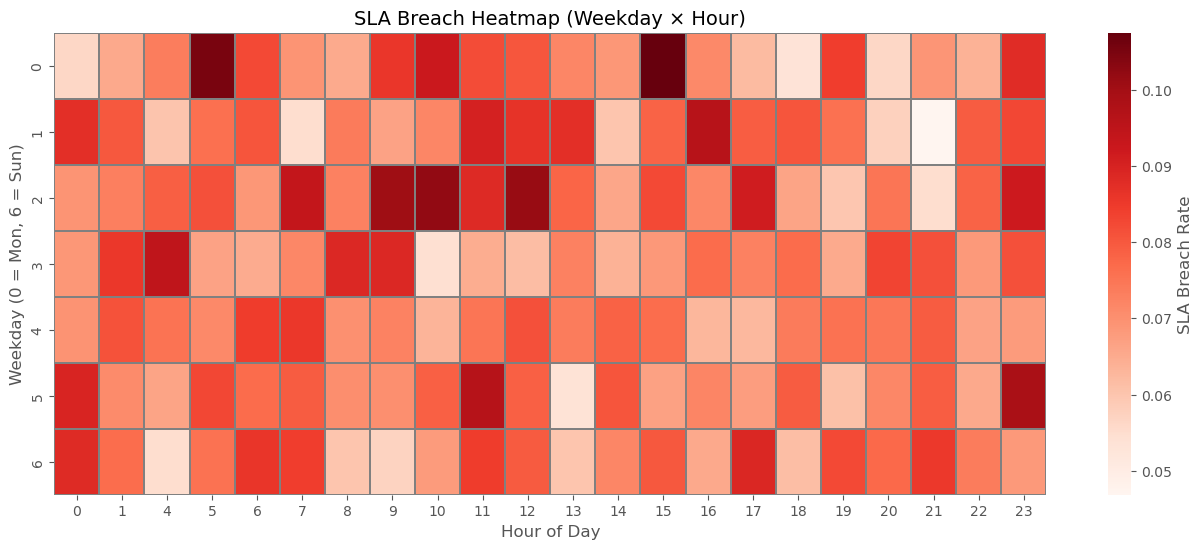

In [16]:
heatmap_data = df.pivot_table(
    values='sla_breach',
    index='order_weekday',
    columns='order_hour',
    aggfunc='mean'
)

plt.figure(figsize=(16, 6))
sns.heatmap(
    heatmap_data,
    cmap="Reds",
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={'label': 'SLA Breach Rate'}
)

plt.title("SLA Breach Heatmap (Weekday × Hour)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Weekday (0 = Mon, 6 = Sun)")

plt.show()


## 2. Key Factors Driving Delivery Delays

We analyzed which dimensions contribute most to SLA breaches across platform, category, customer behavior, and time patterns.

#### Key Results

Platform: Instamart shows the highest delay rate.

Category: Personal Care and Grocery categories cause the most delays.

Order Value: Very high-value orders (₹1000+) have significantly higher breach rates.

Customer Segment: At-Risk customers face the worst delays.

Hour: Severe delay spikes appear at 11 PM, 11 AM, 12 PM, and 5 AM.

Weekday: Wednesday shows the highest delay rate.

#### Result

Delays are driven by operational load, product complexity, and customer/order characteristics, not just random timing.
High-value baskets, certain categories, and specific customer segments face the most service risk.


In [17]:
category_breach = (
    df.groupby('product_category_name')['sla_breach']
      .mean()
      .reset_index()
      .sort_values('sla_breach', ascending=False)
)

print("SLA Breach Rate by Product Category:")
display(category_breach)


SLA Breach Rate by Product Category:


,product_category_name,sla_breach
4,Personal Care,0.102093
3,Grocery,0.096911
0,Beverages,0.070997
1,Dairy,0.063123
5,Snacks,0.059443
2,Fruits & Vegetables,0.058081


In [20]:
platform_delay = (
    df.groupby('platform_name')['sla_breach']
      .mean()
      .reset_index()
      .sort_values('sla_breach', ascending=False)
)

display(platform_delay)


,platform_name,sla_breach
2,Swiggy Instamart,0.084397
0,Blinkit,0.071852
1,JioMart,0.068069


In [23]:
category_delay = (
    df.groupby('product_category_name')['sla_breach']
      .mean()
      .reset_index()
      .sort_values('sla_breach', ascending=False)
)

display(category_delay)


,product_category_name,sla_breach
4,Personal Care,0.102093
3,Grocery,0.096911
0,Beverages,0.070997
1,Dairy,0.063123
5,Snacks,0.059443
2,Fruits & Vegetables,0.058081


In [24]:
# order value buckets
bins = [0, 100, 300, 600, 1000, df['order_value_inr'].max()]
labels = ['0-100', '100-300', '300-600', '600-1000', '1000+']

df['order_value_bucket'] = pd.cut(df['order_value_inr'], bins=bins, labels=labels, include_lowest=True)

# Calculate breach rate by bucket
value_delay = (
    df.groupby('order_value_bucket')['sla_breach']
      .mean()
      .reset_index()
      .sort_values('sla_breach', ascending=False)
)

display(value_delay)


C:\Users\arpit\AppData\Local\Temp\ipykernel_16672\2228240500.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('order_value_bucket')['sla_breach']


,order_value_bucket,sla_breach
4,1000+,0.158101
0,0-100,0.089124
3,600-1000,0.078999
1,100-300,0.069176
2,300-600,0.059856


In [25]:
segment_delay = (
    df.groupby('Segment')['sla_breach']
      .mean()
      .reset_index()
      .sort_values('sla_breach', ascending=False)
)

display(segment_delay)


,Segment,sla_breach
0,At-Risk,0.187617
2,Price-only,0.076550
1,Loyalist,0.058953
3,Promisable,0.049637


In [26]:
hour_delay = (
    df.groupby('order_hour')['sla_breach']
      .mean()
      .reset_index()
      .sort_values('sla_breach', ascending=False)
)

display(hour_delay.head(10))


,order_hour,sla_breach
21,23,0.082860
9,11,0.082402
10,12,0.080355
3,5,0.078691
13,15,0.078251
7,9,0.077462
4,6,0.077339
5,7,0.077267
1,1,0.076786
0,0,0.075677


In [27]:
weekday_delay = (
    df.groupby('order_weekday')['sla_breach']
      .mean()
      .reset_index()
      .sort_values('sla_breach', ascending=False)
)

display(weekday_delay)


,order_weekday,sla_breach
2,2,0.079285
0,0,0.075386
5,5,0.075229
1,1,0.075124
6,6,0.074096
3,3,0.073842
4,4,0.073727


## 3. Refund Analysis: What Leads to Refund Requests?

We analyzed how refunds vary across categories, platforms, customer segments, and delivery performance to understand the main drivers of financial loss.

#### Key Results

Categories: Personal Care and Grocery have the highest refund rates.

Platforms: JioMart shows significantly higher refunds than Blinkit and Instamart.

Customer Segments:

At-Risk customers refund at 30%+ — extremely high.

Loyalists and Promisable segments refund the least.

SLA Impact:

On-time orders refund at 4.6%

Delayed orders refund at 61.3% → delays are the primary cause of refunds.

#### Final answer

Refunds are driven by operational delays, sensitive categories, and high-risk customer groups.
Reducing SLA breaches and improving QC for specific categories would significantly cut refund losses.

In [28]:
category_refund = (
    df.groupby('product_category_name')['refund_requested']
      .mean()
      .reset_index()
      .sort_values('refund_requested', ascending=False)
)

display(category_refund)


,product_category_name,refund_requested
4,Personal Care,0.106810
3,Grocery,0.105634
0,Beverages,0.089441
5,Snacks,0.077103
1,Dairy,0.076887
2,Fruits & Vegetables,0.076599


In [29]:
platform_refund = (
    df.groupby('platform_name')['refund_requested']
      .mean()
      .reset_index()
      .sort_values('refund_requested', ascending=False)
)

display(platform_refund)


,platform_name,refund_requested
1,JioMart,0.113359
0,Blinkit,0.081017
2,Swiggy Instamart,0.079016


In [30]:
segment_refund = (
    df.groupby('Segment')['refund_requested']
      .mean()
      .reset_index()
      .sort_values('refund_requested', ascending=False)
)

display(segment_refund)


,Segment,refund_requested
0,At-Risk,0.308840
2,Price-only,0.090468
1,Loyalist,0.060366
3,Promisable,0.046005


In [31]:
refund_vs_delay = (
    df.groupby('sla_breach')['refund_requested']
      .mean()
      .reset_index()
)

refund_vs_delay['sla_breach'] = refund_vs_delay['sla_breach'].map({0: "On Time", 1: "Delayed"})

display(refund_vs_delay)


,sla_breach,refund_requested
0,On Time,0.046090
1,Delayed,0.613827


## Low Customer Ratings

We analyzed what drives 1–2 star service ratings, focusing on operational delays, refunds, platforms, and categories.

#### Key Results

Delayed orders are 3× more likely to get a low rating (37% vs 12%).

Refunded orders show extremely high dissatisfaction (39% low ratings).

JioMart has the highest low-rating percentage, indicating weaker customer experience.

Snacks and Fruits & Vegetables receive the most low ratings, mainly due to quality and handling issues.

#### Conclusion

Low ratings are driven by delivery delays, refund situations, platform-specific issues, and quality-sensitive categories.
Improving SLA performance and QC for fragile/perishable categories would significantly improve customer satisfaction.

In [35]:
# Create low-rating indicator (1 = bad rating)
df['low_rating'] = (df['service_rating'] <= 2).astype(int)

df['low_rating'].value_counts(normalize=True)

low_rating
0    0.85765
1    0.14235
Name: proportion, dtype: float64

In [36]:
low_rating_vs_delay = (
    df.groupby('sla_breach')['low_rating']
      .mean()
      .reset_index()
)

low_rating_vs_delay['sla_breach'] = low_rating_vs_delay['sla_breach'].map({0: "On Time", 1: "Delayed"})

display(low_rating_vs_delay)


,sla_breach,low_rating
0,On Time,0.123415
1,Delayed,0.375649


In [37]:
low_rating_vs_refund = (
    df.groupby('refund_requested')['low_rating']
      .mean()
      .reset_index()
)

low_rating_vs_refund['refund_requested'] = low_rating_vs_refund['refund_requested'].map({0: "No Refund", 1: "Refund Requested"})

display(low_rating_vs_refund)


,refund_requested,low_rating
0,No Refund,0.117548
1,Refund Requested,0.397137


In [38]:
platform_low_rating = (
    df.groupby('platform_name')['low_rating']
      .mean()
      .reset_index()
      .sort_values('low_rating', ascending=False)
)

display(platform_low_rating)

,platform_name,low_rating
1,JioMart,0.334893
2,Swiggy Instamart,0.087985
0,Blinkit,0.064701


In [39]:
category_low_rating = (
    df.groupby('product_category_name')['low_rating']
      .mean()
      .reset_index()
      .sort_values('low_rating', ascending=False)
)

display(category_low_rating)


,product_category_name,low_rating
5,Snacks,0.153128
2,Fruits & Vegetables,0.153018
1,Dairy,0.149917
0,Beverages,0.147315
3,Grocery,0.128577
4,Personal Care,0.121991
